## Importing Libraries 
Notice: The code works for tensorflow version 1.2.1 as higher order gradients are implemented. We implement all the models on K80 and we highly recommend using a GPU.

In [1]:
%load_ext autoreload
%autoreload 2
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf

def get_session(number=None):
    config_gpu = tf.ConfigProto()
    config_gpu.gpu_options.allow_growth = True
    return tf.Session(config=config_gpu)

Using TensorFlow backend.


## Squeezenet Model:
We slightly modified https://github.com/rcmalli/keras-squeezenet to be able to change the activation function. As described in the paper for attacking integrated gradients and simple gradient saliency maps we replace ReLU activations with Softplus in our saliency loss function gradient (And the perturbed image is applied to the original ReLU network).

In [2]:
from modified_squeezenet import SqueezeNet

## Load images:
80 correctly classified imagenet images. Squeeznet accepts channel mean subtracted images and therefore we subtract the channel mean from the image.

In [3]:
from utils import dataReader
X_dic, y_dic, labels_dic = dataReader()
mean_image = np.zeros((227,227,3))
mean_image[:,:,0]=103.939
mean_image[:,:,1]=116.779
mean_image[:,:,2]=123.68
X = X_dic - mean_image #Mean Subtraction
y = y_dic

## Loading the original and surrogate models:
Surrogate model is exactly the same as original mode but with its ReLU activations replaced by Softplus. 

In [4]:
tf.reset_default_graph()
sess = get_session()
K.set_session(sess)
K.set_learning_phase(0)
model2 = SqueezeNet("softplus")
model = SqueezeNet("relu")

## Saliency Map:
The Simple Gradient saliency map tensor is created for original and surrogate model. As discussed in the paper, we define the saliency map to be sum equal to one. Here, we multiply the sum-one saliency map by image dimensions for avoiding very small values.

In [5]:
def create_saliency_ops(NET):

    logit = NET.layers[-1].input
    w = NET.input.get_shape()[1].value
    h = NET.input.get_shape()[2].value
    num_classes = NET.output.get_shape()[-1].value
    NET.label_ph = tf.placeholder(tf.int32,shape=())
    gradient = tf.gradients(tf.reduce_sum(logit[0]*tf.one_hot(NET.label_ph,num_classes)),NET.input)[0]
    saliency_unnormalized = tf.reduce_sum(tf.abs(gradient),-1)
    NET.saliency = w*h*tf.divide(saliency_unnormalized,tf.reduce_sum(saliency_unnormalized))
    # we multiply the normalized salinecy map with image size to make saliency scores of
    #images of different sizes comparable 
    NET.saliency_flatten = tf.reshape(NET.saliency,[w*h])
    
create_saliency_ops(model)
create_saliency_ops(model2)

## Test Image:
A correctly classified ImageNET image is randomly chosen.

Image Label : container_ship


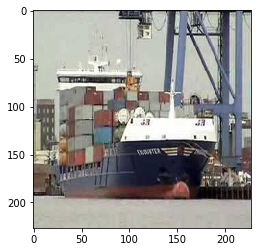

In [6]:
n = np.random.choice(X.shape[0])
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image Label : {}".format(labels_dic[y[n]]))
%matplotlib inline
plt.imshow((X[n,:,:,::-1]+mean_image[:,:,::-1])/255)

## Call the perturbation module:
We create the attack object with our own parameters. The object is feeded with the mean subtracted image. The recommended k_top parameter for ImageNET is 1000. (Refer to the paper for description of the parameter).  We used the channel mean Image as the reference image which after channel mean subtraction would be all-zero.

In [7]:
k_top = 1000 #Recommended for ImageNet
from utils import SimpleGradientAttack
module = SimpleGradientAttack(mean_image, sess, test_image, original_label,NET=model, NET2=model2, k_top=k_top)

## Attack:
The attack method should be one of "random", "mass_center", or "topK". "mass_center" usually results in the best visual change in the saliency map. In cases that "mass_center" fails, "topK" could be used and vice versa. To have unperceivable perturbations, epsilon is recommended to be less than 16. 

In [9]:
method = "mass_center" #Method should be one of "random", "mass_center", "topK"
epsiolon = 8 #Maximum allowed perturbation for each pixel
output = module.iterative_attack(method, epsilon=epsiolon, alpha=0.5, iters=300, measure="intersection")
print("The prediction confidence changes from {} to {} after perturbation.".format(module.original_confidence,output[-1]))
print('''{} % of the {} most salient pixels in the original image are among {} most salient pixels of the 
perturbed image'''.format(output[0]*100,k_top,k_top))
print("The rank correlation between salieny maps is equal to {}".format(output[1]))
print("The L2 distance between mass centers of saliencies is {} pixels.".format(output[2]))

Iteration : 0
Iteration : 60
Iteration : 120
Iteration : 180
Iteration : 240
For maximum allowed perturbation size equal to 8, the resulting perturbation size was equal to 8.0
        
The prediction confidence changes from 0.4830630421638489 to 8.0 after perturbation.
1.0 % of the 1000 most salient pixels in the original image are among 1000 most salient pixels of the 
perturbed image
The rank correlation between salieny maps is equal to 0.2508088506980329
The L2 distance between mass centers of saliencies is 86.2670273047588 pixels.


## Time for depiction...

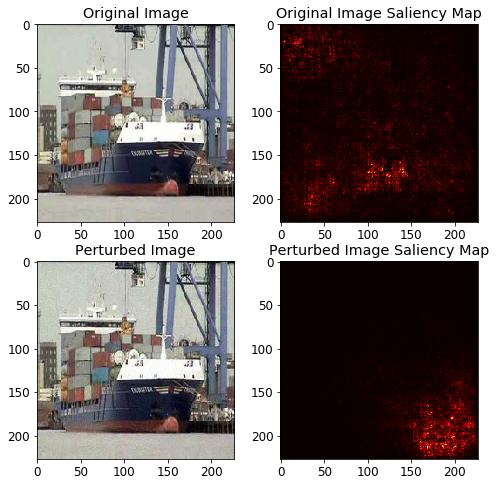

In [11]:
gradient = sess.run(tf.gradients(model.layers[-1].input[0,original_label],model.input)[0],
                    {model.input:[test_image]})[0]
mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(gradient),-1)
original_saliency = 227*227*saliency/np.sum(saliency)
plt.subplot(2,2,1)
plt.title("Original Image")
image = X[n,:,:,::-1]+mean_image[:,:,::-1]
plt.imshow(image/255)
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(original_saliency,cmap="hot")
gradient = sess.run(tf.gradients(model.layers[-1].input[0,original_label],model.input)[0],
                    {model.input:[module.perturbed_image]})[0]
saliency = np.sum(np.abs(gradient),-1)
perturbed_saliency = 227*227*saliency/np.sum(saliency)
plt.subplot(2,2,3)
plt.title("Perturbed Image")
perturbed_image = (module.perturbed_image[:,:,::-1]+mean_image[:,:,::-1])
plt.imshow(perturbed_image/255)
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(perturbed_saliency,cmap="hot")